In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import odeint
import time
from IPython import display
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20  
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlepad'] = 40 
plt.rcParams['axes.labelpad'] = 16 

In [2]:
#Constants:
T = 273
P = 1 #bar
H2O = 1.0

#Minerals:
FeS2 = 1.0
FeOOH = 1.0 #since it's a mineral
ker415 = 1.0

#pH-dependent concentrations:
pH = np.array([9.0, 11.0])
H = 10**(-pH)

#Reductants
H2 = np.array([1e-4, 2e-7])
CH4 = np.array([3e-5, 4e-8])

#Oxidants
CO2 = np.array([7e-5, 1e-7])

#kerogen:
ker = 3e-4

In [5]:
#Reactions - let's split these up between methanogenesis, aerobic, & anaerobic reactions
#K values calculated for T = 0.0C and P = 74bar (from Chris's book chapter)

##Methanogenesis##
# this will just have 2 values - for pH 9 and pH 11
r1 = '4H2 + CO2 = CH4 + 2H2O                  '
K1 = 37.512 #at 0 deg C, 75 bar, from Chris's book chapter
Q1 = np.log10(CH4) + 2*np.log10(H2O) - np.log10(CO2) - 4*np.log10(H2)

##Aerobic reactions##

#2 hydrocarbon oxidation
r2 = ('0.5CH4 + O2 = 0.5CO2 + H2O', '0.25CH4 + H2O2 = 0.25CO2 + 6/4H2O')
K2 = np.array([82.253,59.397])

#3 sulfide oxidation
r3 = ('0.5HS + O2 = 0.5SO4 + 0.5H', '0.25HS + H2O2 = 0.25SO4 + 0.25H + H2O')                       
K3 = np.array([76.095,56.318])

#4 iron sulfide oxidation
r4 = ('(2/7)FeS2 + O2 + (2/7)H2O = (2/7)Fe(II) + (4/7)SO4 + (4/7)H+', 
      '(1/7)FeS2 + H2O2 = (1/7)Fe(II) + (2/7)SO4 + (2/7)H + (6/7)H2O')
K4 = np.array([68.535, 52.538])

#5 hydrogen oxidation
r5 = ('2H2 + O2 = 2H2O', 'H2 + H2O2 = 2H2O')                         
K5 = np.array([101.009, 68.7754])

##Anaerobic Reactions##

#6 sulfate reduction
r6 = '4H2 + SO4 + H+ = HS + 4H2O              '
K6 = 49.827

#7 anaerobic oxidation of methane
r7 = 'CH4 + SO4 + H = CO2 + HS + 2H2O         '
K7 = 12.317

#8 Reduction of ferric iron
r8 = '0.5H2 + FeOOH + 2H+ = 2H2O + Fe(II)       '
K8 = 16.514

#9 Aerobic Kerogen Oxidation
r9 = ('(1/404)C415H698O22 + O2 = (415/404)CO2 + (349/404)H2', 
      '(1/404)C415H698O22 + H2O2 = (415/404)CO2 + (753/404)H2')
K9 = np.array([76.0367,  43.803])

#10 Anaerobic Kerogen Oxidation
r10a = '(4/1157)415H698O22 + SO4 + H+ = (1660/1157)CO2 + HS- + (1396/1157)H2O'
K10a = 14.948
r10b = '(415/2314)C415H698O22 + FeOOH + 2H+ = (415/2314)CO2 + Fe{2+} + (1910/1157)H2O'
K10b = 12.155


# rxns = np.array([r1, r2, r3, r4, r5, r6, r7, r8])
# K = np.array([K1, K2, K3, K4, K5, K6, K7, K8])


In [6]:
#Affinity:
def A(T, K, Q):
	R = 8.31446 #J mol^-1 K^-1
	A = (2.3026 * R * T * (K - Q))/1000.0
	return A


#Power:
H2_mix = np.array([0.004, 0.014])
plume_v = 200.0 #kg/s

#convert mixing ratios to annual production rates
def mix_to_rate(mix, v):
    return v*(1000.0/18.015)*(3600*24*365)*mix

r_H2 = mix_to_rate(H2_mix, plume_v)
r_ker = mix_to_rate(ker, plume_v)
print(r_ker)

#calculate power
def power(aff, rate):
    return (aff*1000.0)*(rate/(3600*24*365)) #(J/mol)*(mol/s) = J/s = W

105032472.9392173


In [7]:
#methanogenesis:
meth_aff = A(T,K1,Q1) 
print('Methanogenesis Affinity: %3d, %3d' %(meth_aff[0], meth_aff[1]))

P_meth_1 = power(meth_aff,r_H2[0]) 
P_meth_2 = power(meth_aff,r_H2[1]) 
print('Methanogenesis, pH = 9: %.1e, %.1e' %(P_meth_1[0], P_meth_1[1]))
print('Methanogenesis, pH = 9: %.1e, %.1e' %(P_meth_2[0], P_meth_2[1]))
P_meth = np.array([P_meth_1[1], P_meth_2[0]])

Methanogenesis Affinity: 114,  58
Methanogenesis, pH = 9: 5.1e+06, 2.6e+06
Methanogenesis, pH = 9: 1.8e+07, 9.0e+06


In [8]:
###Region one: ice-water interface OR Case I (No reductants)###

#Two total possibilities: O2 or H2O2

#Old Enceladus:
fname = open('Oxidants.txt')

#Young Enceladus:
#fname = open('YoungEnceladus_Oxidants.txt')


for i, lines in enumerate(fname):
    if i == 2: 
        case_I = lines.split()
        O2_I = float(case_I[1]) #concentration for both pH 9 & 11
        rO2 = float(case_I[2]) #since the production rate of O2/H2O2 is always the same
    if i == 3: 
        case_II = lines.split()
        H2O2_I = float(case_II[1]) 
        rH2O2 = float(case_II[2])
fname.close()

#Picking low concentrations for reductants, informed somewhat by time constants
HS_I = 1e-18
Fe_I = 1e-20

#Using the equilibrium expression for HS -> SO4:
K_SO4 = -49.827
log_SO4_I = K_SO4 + np.log10(HS_I) + pH - 4*np.log10(H2)
SO4_I = 10**log_SO4_I

#Reaction Quotients:
#Oxygen Reactions:

#methane oxidation: '0.5CH4 + O2 = 0.5CO2 + H2O', 
                    #     '0.25CH4 + H2O2 = 0.25CO2 + 6/4H2O'
Q2 = np.array([(0.5*np.log10(CO2[0]) + np.log10(H2O) - 0.5*np.log10(CH4[0]) - np.log10(O2_I)), 
               (0.5*np.log10(CO2[1]) + np.log10(H2O) - 0.5*np.log10(CH4[1]) - np.log10(O2_I)),
               (0.25*np.log10(CO2[0]) + (6/4)*np.log10(H2O) - 0.25*np.log10(CH4[0]) - np.log10(H2O2_I)),
               (0.25*np.log10(CO2[1]) + (6/4)*np.log10(H2O) - 0.25*np.log10(CH4[1]) - np.log10(H2O2_I))])
aff_2I = np.zeros(4)
P_2I = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_2I[i] = A(T,K2[0],Q2[i])
        P_2I[i] = power(aff_2I[i], rO2)
    else:
        aff_2I[i] = A(T,K2[1],Q2[i])
        P_2I[i] = power(aff_2I[i], rH2O2)

 
#3 sulfide oxidation: '0.5HS + O2 = 0.5SO4 + 0.5H', 
#                     '0.25*HS + H2O2 = 0.25*SO4 + 0.25*H + H2O')                      '
Q3 = np.array([(0.5*np.log10(H[0]) + 0.5*np.log10(SO4_I[0]) - np.log10(O2_I) - 0.5*np.log10(HS_I)),
              (0.5*np.log10(H[1]) + 0.5*np.log10(SO4_I[1]) - np.log10(O2_I) - 0.5*np.log10(HS_I)),
              (0.25*np.log10(H[0]) + 0.25*np.log10(SO4_I[0]) + np.log10(H2O) - np.log10(H2O2_I) - 0.25*np.log10(HS_I)),
              (0.25*np.log10(H[1]) + 0.25*np.log10(SO4_I[1]) + np.log10(H2O) - np.log10(H2O2_I) - 0.25*np.log10(HS_I))])
aff_3I = np.zeros(4)
P_3I = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_3I[i] = A(T,K3[0],Q3[i])
        P_3I[i] = power(aff_3I[i], rO2)
    else:
        aff_3I[i] = A(T,K3[1],Q3[i])
        P_3I[i] = power(aff_3I[i], rH2O2)


#4 iron sulfide oxidation:
Q4 = np.array([((2/7)*np.log10(Fe_I) + (4/7)*np.log10(SO4_I[0]) + (4/7)*np.log10(H[0]) - (2/7)*np.log10(H2O) - np.log10(O2_I) - (2/7)*np.log10(FeS2)),
              ((2/7)*np.log10(Fe_I) + (4/7)*np.log10(SO4_I[1]) + (4/7)*np.log10(H[1]) - (2/7)*np.log10(H2O) - np.log10(O2_I) - (2/7)*np.log10(FeS2)),
              ((1/7)*np.log10(Fe_I) + (2/7)*np.log10(SO4_I[0]) + (2/7)*np.log10(H[0]) + (6/7)*np.log10(H2O) - np.log10(H2O2_I) - (1/7)*np.log10(FeS2)),
              ((1/7)*np.log10(Fe_I) + (2/7)*np.log10(SO4_I[1]) + (2/7)*np.log10(H[1]) + (6/7)*np.log10(H2O) - np.log10(H2O2_I) - (1/7)*np.log10(FeS2))])
aff_4I = np.zeros(4)
P_4I = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_4I[i] = A(T,K4[0],Q4[i])
        P_4I[i] = power(aff_4I[i], rO2)
    else:
        aff_4I[i] = A(T,K4[1],Q4[i])
        P_4I[i] = power(aff_4I[i], rH2O2)

#5 hydrogen oxidation: 2H2 + O2 = 2H2O   
#                     'H2 + H2O2 = 2H2O''
Q5 = np.array([(2*np.log10(H2O) - 2*np.log10(H2[0]) - np.log10(O2_I)),
               (2*np.log10(H2O) - 2*np.log10(H2[1]) - np.log10(O2_I)),
               (2*np.log10(H2O) - np.log10(H2[0]) - np.log10(H2O2_I)),
               (2*np.log10(H2O) - np.log10(H2[1]) - np.log10(H2O2_I))])
aff_5I = np.zeros(4)
P_5I = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_5I[i] = A(T,K5[0],Q5[i])
        P_5I[i] = power(aff_5I[i], rO2)
    else:
        aff_5I[i] = A(T,K5[1],Q5[i])
        P_5I[i] = power(aff_5I[i], rH2O2)

#5 aerobic kerogen oxidation : ('(1/404)C415H698O22 + O2 = (415/404)CO2 + (349/404)H2', 
#      '(1/404)C415H698O22 + H2O2 = (415/404)CO2 + (753/404)H2')                     '
Q9 = np.array([((415/404)*np.log10(CO2[0]) + (349/404)*np.log10(H2[0]) - (1/404)*np.log10(ker415) - np.log10(O2_I)),
               ((415/404)*np.log10(CO2[1]) + (349/404)*np.log10(H2[1]) - (1/404)*np.log10(ker415) - np.log10(O2_I)),
               ((415/404)*np.log10(CO2[0]) + (753/404)*np.log10(H2[0]) - (1/404)*np.log10(ker415) - np.log10(H2O2_I)),
               ((415/404)*np.log10(CO2[1]) + (753/404)*np.log10(H2[1]) - (1/404)*np.log10(ker415) - np.log10(H2O2_I))])
aff_9I = np.zeros(4)
P_9I = np.zeros(4)
for i in range(0,4):
    if i in (0,1):
        aff_9I[i] = A(T,K9[0],Q9[i])
        P_9I[i] = power(aff_9I[i], rO2)
    else:
        aff_9I[i] = A(T,K9[1],Q9[i])
        P_9I[i] = power(aff_9I[i], rH2O2)
        
        
print("Case I: Oxidant buildup - low concentrations of sulfur/iron")
print(" ")
print("Affinities:")
print(" ")
print("1. methane oxidation with O2, pH = 9 & 11: %.1f, %.1f" %(aff_2I[0],aff_2I[1]))
print("   methane oxidation with H2O2, pH = 9 & 11: %.1f, %.1f" %(aff_2I[2],aff_2I[3]))
print("2. sulfide oxidation with O2, pH = 9 & 11: %.1f, %.1f" %(aff_3I[0],aff_3I[1]))
print("   sulfide oxidation with H2O2, pH = 9 & 11: %.1f, %.1f" %(aff_3I[2],aff_3I[3]))
print("3. iron sulfide oxidation with O2, pH = 9 & 11: %.1f, %.1f" %(aff_4I[0],aff_4I[1]))
print("   iron sulfide oxidation with H2O2, pH = 9 & 11: %.1f, %.1f" %(aff_4I[2],aff_4I[3]))
print("4. hydrogen oxidation, pH = 9 & 11: %.1f, %.1f" %(aff_5I[0],aff_5I[1]))
print("   hydrogen oxidation, pH = 9 & 11: %.1f, %.1f" %(aff_5I[2],aff_5I[3]))
print("4. kerogen oxidation with O2, pH = 9 & 11: %.1f, %.1f" %(aff_9I[0],aff_9I[1]))
print("   kerogen oxidation with H2O2, pH = 9 & 11: %.1f, %.1f" %(aff_9I[2],aff_9I[3]))

print(" ")
print("Power:")
print(" ")
print("1. methane oxidation, pH = 9 & 11: %.1e, %.1e" %(P_2I[0], P_2I[1]))
print("   methane oxidation, pH = 9 & 11: %.1e, %.1e" %(P_2I[2], P_2I[3]))
print("2. sulfide oxidation, pH = 9 & 11: %.1e, %.1e" %(P_3I[0], P_3I[1]))
print("   sulfide oxidation, pH = 9 & 11: %.1e, %.1e" %(P_3I[2], P_3I[3]))
print("3. iron sulfide oxidation, pH = 9 & 11: %.1e, %.1e" %(P_4I[0], P_4I[1]))
print("   iron sulfide oxidation, pH = 9 & 11: %.1e, %.1e" %(P_4I[2], P_4I[3]))
print("4. hydrogen oxidation, pH = 9 & 11: %.1e, %.1e" %(P_5I[0], P_5I[1]))
print("   hydrogen oxidation, pH = 9 & 11: %.1e, %.1e" %(P_5I[2], P_5I[3]))
print("4. kerogen oxidation, pH = 9 & 11: %.1e, %.1e" %(P_9I[0], P_9I[1]))
print("   kerogen oxidation, pH = 9 & 11: %.1e, %.1e" %(P_9I[2], P_9I[3]))

#Combined Powers for all Case I aerobes:
P_I = np.append(P_2I, np.append(P_3I,np.append(P_4I,np.append(P_5I, P_9I))))

Case I: Oxidant buildup - low concentrations of sulfur/iron
 
Affinities:
 
1. methane oxidation with O2, pH = 9 & 11: 415.3, 415.3
   methane oxidation with H2O2, pH = 9 & 11: 296.9, 296.8
2. sulfide oxidation with O2, pH = 9 & 11: 472.5, 444.3
   sulfide oxidation with H2O2, pH = 9 & 11: 325.4, 311.3
3. iron sulfide oxidation with O2, pH = 9 & 11: 529.3, 497.0
   iron sulfide oxidation with H2O2, pH = 9 & 11: 353.8, 337.7
4. hydrogen oxidation, pH = 9 & 11: 472.5, 444.3
   hydrogen oxidation, pH = 9 & 11: 325.4, 311.3
4. kerogen oxidation with O2, pH = 9 & 11: 424.2, 451.6
   kerogen oxidation with H2O2, pH = 9 & 11: 277.1, 318.7
 
Power:
 
1. methane oxidation, pH = 9 & 11: 1.1e+05, 1.1e+05
   methane oxidation, pH = 9 & 11: 1.1e+05, 1.1e+05
2. sulfide oxidation, pH = 9 & 11: 1.2e+05, 1.1e+05
   sulfide oxidation, pH = 9 & 11: 1.2e+05, 1.2e+05
3. iron sulfide oxidation, pH = 9 & 11: 1.4e+05, 1.3e+05
   iron sulfide oxidation, pH = 9 & 11: 1.3e+05, 1.3e+05
4. hydrogen oxidation, pH =

In [440]:
SO4_I

array([  1.48936108e-43,   9.30850674e-31])

In [9]:
###Region two: sediment (aqueous reductants) ###

#2) 4 different O2 aqueous concentrations (pH 9, aSiO2 = -8,-3, pH11, aSiO2 = -8, -3)
#3) 4 different H2O2 aqueous concentrations

HS = np.array([3.09e-6, 3.535e-5, 3.082e-6, 1.753e-4,3.09e-6, 3.535e-5, 3.082e-6, 1.753e-4])
Fe2 = np.array([1.415e-6, 2.912e-8, 1.374e-9, 1.323e-12, 1.415e-6, 2.912e-8, 1.374e-9, 1.323e-12])

O2_aq = np.zeros(4)
H2O2_aq = np.zeros(4)

SO4_aq = np.zeros(8)
rSO4_aq = np.zeros(8)
rFeOOH_aq = np.zeros(8) #only rate - activity is 1

#Old Enceladus:
fname = open('Oxidants.txt')

#Young Enceladus:
#fname = open('YoungEnceladus_Oxidants.txt')

for i, lines in enumerate(fname):
    #Aqueous O2, pH = 9
    if i == 7:
        aqO2_case9 = lines.split()
        O2_aq[0] = aqO2_case9[1] #aSiO2 = -8
        O2_aq[1] = aqO2_case9[3] #aSiO2 = -3
    if i == 8:
        aqSO4_case9 = lines.split()
        SO4_aq[0] = aqSO4_case9[1] #aSiO2 = -8
        rSO4_aq[0] = aqSO4_case9[2] #aSiO2 = -8
        SO4_aq[1] = aqSO4_case9[3] #aSiO2 = -3
        rSO4_aq[1] = aqSO4_case9[4] #aSiO2 = -3
    if i == 9:
        aqFeOOH_case9 = lines.split()
        rFeOOH_aq[0] = aqFeOOH_case9[2]
        rFeOOH_aq[1] = aqFeOOH_case9[4]
    #Aqueous O2, pH = 11
    if i == 12:
        aqO2_case11 = lines.split()
        O2_aq[2] = aqO2_case11[1] #aSiO2 = -8
        O2_aq[3] = aqO2_case11[3] #aSiO2 = -3
    if i == 13:
        aqSO4_case11 = lines.split()
        SO4_aq[2] = aqSO4_case11[1] #aSiO2 = -8
        rSO4_aq[2] = aqSO4_case11[2] #aSiO2 = -8
        SO4_aq[3] = aqSO4_case11[3] #aSiO2 = -3
        rSO4_aq[3] = aqSO4_case11[4] #aSiO2 = -3
    if i == 14:
        aqFeOOH_case11 = lines.split()
        rFeOOH_aq[2] = aqFeOOH_case11[2]
        rFeOOH_aq[3] = aqFeOOH_case11[4]
    #Aqueous H2O2, pH = 9
    if i == 17:
        aqH2O2_case9 = lines.split()
        H2O2_aq[0] = aqH2O2_case9[1] #aSiO2 = -8
        H2O2_aq[1] = aqH2O2_case9[3] #aSiO2 = -3
    if i == 18:
        aqSO4_case9 = lines.split()
        SO4_aq[4] = aqSO4_case9[1] #aSiO2 = -8
        rSO4_aq[4] = aqSO4_case9[2] #aSiO2 = -8
        SO4_aq[5] = aqSO4_case9[3] #aSiO2 = -3
        rSO4_aq[5] = aqSO4_case9[4] #aSiO2 = -3
    if i == 19:
        aqFeOOH_case9 = lines.split()
        rFeOOH_aq[4] = aqFeOOH_case9[2]
        rFeOOH_aq[5] = aqFeOOH_case9[4]
    #Aqueous H2O2, pH = 11
    if i == 22:
        aqH2O2_case11 = lines.split()
        H2O2_aq[2] = aqH2O2_case11[1] #aSiO2 = -8
        H2O2_aq[3] = aqH2O2_case11[3] #aSiO2 = -3
    if i == 23:
        aqSO4_case11 = lines.split()
        SO4_aq[6] = aqSO4_case11[1] #aSiO2 = -8
        rSO4_aq[6] = aqSO4_case11[2] #aSiO2 = -8
        SO4_aq[7] = aqSO4_case11[3] #aSiO2 = -3
        rSO4_aq[7] = aqSO4_case11[4] #aSiO2 = -3
    if i == 24:
        aqFeOOH_case11 = lines.split()
        rFeOOH_aq[6] = aqFeOOH_case11[2]
        rFeOOH_aq[7] = aqFeOOH_case11[4]
fname.close()

In [10]:
SO4_aq

array([  2.28340000e-06,   6.30720000e-04,   2.34930000e-07,
         1.14790000e-03,   1.55860000e-08,   8.56880000e-06,
         9.97790000e-08,   6.85820000e-04])

In [11]:
#Reaction Quotients:
#Oxygen Reactions:

#2 methane oxidation: CH4 + 2O2 = CO2 + 2H2O 
aff_2II = np.zeros(8)
P_2II = np.zeros(8)
Q2 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):
        Q2[i] = 0.5*np.log10(CO2[0]) + np.log10(H2O) - 0.5*np.log10(CH4[0]) - np.log10(O2_aq[i])
        Q2[i+4] = 0.25*np.log10(CO2[0]) + (6/4)*np.log10(H2O) - 0.25*np.log10(CH4[0]) - np.log10(H2O2_aq[i])
    else:
        Q2[i] = 0.5*np.log10(CO2[1]) + np.log10(H2O) - 0.5*np.log10(CH4[1]) - np.log10(O2_aq[i])
        Q2[i+4] = 0.25*np.log10(CO2[1]) + (6/4)*np.log10(H2[1]) - 0.25*np.log10(CH4[1]) - np.log10(H2O2_aq[i])
aff_2II[0:4] = A(T,K2[0],Q2[0:4])
aff_2II[4:] = A(T,K2[1],Q2[4:])
P_2II[0:4] = power(aff_2II[0:4], rO2)
P_2II[4:] = power(aff_2II[4:], rH2O2)

#3 sulfide oxidation:
aff_3II = np.zeros(8)
P_3II = np.zeros(8)
Q3 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):
        Q3[i] = 0.5*np.log10(H[0]) + 0.5*np.log10(SO4_aq[i]) - np.log10(O2_aq[i]) - 0.5*np.log10(HS[i])
        Q3[i+4] = 0.25*np.log10(H[0]) + 0.25*np.log10(SO4_aq[i]) + np.log10(H2O) - np.log10(H2O2_aq[i]) - 0.25*np.log10(HS[i])
    else:
        Q3[i] = 0.5*np.log10(H[1]) + 0.5*np.log10(SO4_aq[i]) - np.log10(O2_aq[i]) - 0.5*np.log10(HS[i])
        Q3[i+4] = 0.25*np.log10(H[1]) + 0.25*np.log10(SO4_aq[i]) + np.log10(H2O) - np.log10(H2O2_aq[i]) - 0.25*np.log10(HS[i])
aff_3II[0:4] = A(T,K3[0],Q3[0:4])
aff_3II[4:] = A(T,K3[1],Q3[4:])
P_3II[0:4] = power(aff_3II[0:4], rO2)
P_3II[4:] = power(aff_3II[4:], rH2O2)

#4 iron sulfide oxidation:
aff_4II = np.zeros(8)
P_4II = np.zeros(8)
Q4 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):    
        Q4[i] = (4/7)*np.log10(SO4_aq[i]) + (2/7)*np.log10(Fe2[i]) + (4/7)*np.log10(H[0]) - (2/7)*np.log10(H2O) - np.log10(O2_aq[i]) - (2/7)*np.log10(FeS2)
        Q4[i+4] = (2/7)*np.log10(SO4_aq[i]) + (1/7)*np.log10(Fe2[i]) + (2/7)*np.log10(H[0]) + (6/7)*np.log10(H2O) - np.log10(H2O2_aq[i]) - (1/7)*np.log10(FeS2)
    else:
        Q4[i] = (4/7)*np.log10(SO4_aq[i]) + (2/7)*np.log10(Fe2[i]) + (4/7)*np.log10(H[1]) - (2/7)*np.log10(H2O) - np.log10(O2_aq[i]) - (2/7)*np.log10(FeS2)
        Q4[i+4] = (2/7)*np.log10(SO4_aq[i]) + (1/7)*np.log10(Fe2[i]) + (2/7)*np.log10(H[1]) + (6/7)*np.log10(H2O) - np.log10(H2O2_aq[i]) - (1/7)*np.log10(FeS2)
aff_4II[0:4] = A(T,K4[0],Q4[0:4])
aff_4II[4:] = A(T,K4[1],Q4[4:])
P_4II[0:4] = power(aff_4II[0:4], rO2)
P_4II[4:] = power(aff_4II[4:], rH2O2)

#5 hydrogen oxidation: 2H2 + O2 = 2H2O
aff_5II = np.zeros(8)
P_5II = np.zeros(8)
Q5 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):
        Q5[i] = 2*np.log10(H2O) - 2*np.log10(H2[0]) - np.log10(O2_aq[i])
        Q5[i+4] = 2*np.log10(H2O) - 1*np.log10(H2[0]) - np.log10(H2O2_aq[i])
    else:
        Q5[i] = 2*np.log10(H2O) - 2*np.log10(H2[1]) - np.log10(O2_aq[i])
        Q5[i+4] = 2*np.log10(H2O) - 1*np.log10(H2[1]) - np.log10(H2O2_aq[i])
aff_5II[0:4] = A(T,K5[0],Q5[0:4])
aff_5II[4:] = A(T,K5[1],Q5[4:])
P_5II[0:4] = power(aff_5II[0:4], rO2)
P_5II[4:] = power(aff_5II[4:], rH2O2)


#5 aerobic kerogen oxidation : ('(1/404)C415H698O22 + O2 = (415/404)CO2 + (349/404)H2', 
#      '(1/404)C415H698O22 + H2O2 = (415/404)CO2 + (753/404)H2') 
aff_9II = np.zeros(8)
P_9II = np.zeros(8)
Q9 = np.zeros(8)
for i in range(0,4):
    if i in (0,1):
        Q9[i] = (415/404)*np.log10(CO2[0]) + (349/404)*np.log10(H2[0]) - (1/404)*np.log10(ker415) - np.log10(O2_aq[i])
        Q9[i+4] = (415/404)*np.log10(CO2[0]) + (753/404)*np.log10(H2[0]) - (1/404)*np.log10(ker415) - np.log10(H2O2_aq[i])
    else:
        Q9[i] = (415/404)*np.log10(CO2[1]) + (349/404)*np.log10(H2[1]) - (1/404)*np.log10(ker415) - np.log10(O2_aq[i])
        Q9[i+4] = (415/404)*np.log10(CO2[1]) + (753/404)*np.log10(H2[1]) - (1/404)*np.log10(ker415) - np.log10(H2O2_aq[i])
aff_9II[0:4] = A(T,K9[0],Q9[0:4])
aff_9II[4:] = A(T,K9[1],Q9[4:])
P_9II[0:4] = power(aff_9II[0:4], rO2)
P_9II[4:] = power(aff_9II[4:], rH2O2)

#Combined Powers for all Case II aerobes:
Pae_II = np.append(P_2II, np.append(P_3II,np.append(P_4II, np.append(P_5II, P_9II))))

##Anaerobic Reactions##

#6 sulfate reduction 4H2 + SO4 + H+ = HS + 4H2O
Q6 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5):    
        Q6[i] = np.log10(HS[i]) + 4*np.log10(H2O) - np.log10(SO4_aq[i]) - np.log10(H[0]) - 4*np.log10(H2[0])
    else:
        Q6[i] = np.log10(HS[i]) + 4*np.log10(H2O) - np.log10(SO4_aq[i]) - np.log10(H[1]) - 4*np.log10(H2[1])
aff_6II = A(T,K6,Q6)
P_6II = power(aff_6II, rSO4_aq)

#7 anaerobic oxidation of methane CH4 + SO4 + H = CO2 + HS + 2H2O
Q7 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q7[i] = np.log10(CO2[0]) + np.log10(HS[i]) + 2*np.log10(H2O) - np.log10(CH4[0]) - np.log10(SO4_aq[i]) - np.log10(H[0])
    else:
        Q7[i] = np.log10(CO2[1]) + np.log10(HS[i]) + 2*np.log10(H2O) - np.log10(CH4[1]) - np.log10(SO4_aq[i]) - np.log10(H[1])
aff_7II = A(T,K7,Q7)
P_7II = power(aff_7II, rSO4_aq)

#8 Reduction of ferric iron FeOOH + 2H + 0.5H2 = 2H2O + 1Fe(II)
Q8 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q8[i] = 2*np.log10(H2O) + np.log10(Fe2[i]) - 0.5*np.log10(H2[0]) - 2*np.log10(H[0]) - np.log10(FeOOH)
    else:
        Q8[i] = 2*np.log10(H2O) + np.log10(Fe2[i]) - 0.5*np.log10(H2[1]) - 2*np.log10(H[1]) - np.log10(FeOOH)
aff_8II = A(T,K8,Q8)
P_8II = power(aff_8II, rFeOOH_aq)        

Pan_II = np.append(P_6II,np.append(P_7II,P_8II))

#10a anaerobic kerogen oxidation w/sulfur
Q10a = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q10a[i] = (1396/1157)*np.log10(H2O) + np.log10(HS[i]) + (1660/1157)*np.log10(CO2[0]) - np.log10(H[0]) - np.log10(SO4_aq[i]) - (4/1157)*np.log10(ker415)
    else:
        Q10a[i] = (1396/1157)*np.log10(H2O) + np.log10(HS[i]) + (1660/1157)*np.log10(CO2[1]) - np.log10(H[1]) - np.log10(SO4_aq[i]) - (4/1157)*np.log10(ker415)
aff_10aII = A(T,K10a,Q10a)
P_10aII = power(aff_10aII, rSO4_aq)        

#10a anaerobic kerogen oxidation w/sulfur
Q10b = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q10b[i] = (1910/1157)*np.log10(H2O) + np.log10(Fe2[i]) + (415/2314)*np.log10(CO2[0]) - 2*np.log10(H[0]) - np.log10(FeOOH) - (1/2314)*np.log10(ker415)
    else:
        Q10b[i] = (1910/1157)*np.log10(H2O) + np.log10(Fe2[i]) + (415/2314)*np.log10(CO2[1]) - 2*np.log10(H[1]) - np.log10(FeOOH) - (1/2314)*np.log10(ker415)
aff_10bII = A(T,K10b,Q10b)
P_10bII = power(aff_10bII, rFeOOH_aq)  

Pan_II = np.append(P_6II,np.append(P_7II, np.append(P_8II,np.append(P_10aII, P_10bII))))





In [12]:
SO4_aq

array([  2.28340000e-06,   6.30720000e-04,   2.34930000e-07,
         1.14790000e-03,   1.55860000e-08,   8.56880000e-06,
         9.97790000e-08,   6.85820000e-04])

In [13]:
O2_aq

array([  1.15530000e-15,   2.78950000e-14,   1.19180000e-16,
         1.02370000e-14])

In [14]:

print("Case II: Aqueous Reductants, O2")
print(" ")
print("Affinities, Aerobic Reactions:")
print(" ")
print("1. methane oxidation with O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_2II[0], aff_2II[1], aff_2II[2], aff_2II[3]))
print("   methane oxidation with H2O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_2II[4], aff_2II[5], aff_2II[6], aff_2II[7]))
print("2. sulfide oxidation with O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_3II[0], aff_3II[1], aff_3II[2], aff_3II[3]))
print("   sulfide oxidation with H2O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_3II[4], aff_3II[5], aff_3II[6], aff_3II[7]))
print("3. iron sulfide oxidation with O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_4II[0], aff_4II[1], aff_4II[2], aff_4II[3]))
print("   iron sulfide oxidation with H2O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_4II[4], aff_4II[5], aff_4II[6], aff_4II[7]))
print("4. hydrogen oxidation with O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_5II[0], aff_5II[1], aff_5II[2], aff_5II[3]))
print("   hydrogen oxidation with H2O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_5II[4], aff_5II[5], aff_5II[6], aff_5II[7]))
print("5. kerogen oxidation with O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_9II[0], aff_9II[1], aff_9II[2], aff_9II[3]))
print("   kerogen oxidation with H2O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_9II[4], aff_9II[5], aff_9II[6], aff_9II[7]))
print(" ")
print("Anaerobic Reactions:")
print(" ")
print("6. sulfate reduction (from O2), pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_6II[0], aff_6II[1], aff_6II[2], aff_6II[3]))
print("   sulfate reduction (from H2O2), pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_6II[4], aff_6II[5], aff_6II[6], aff_6II[7]))
print("7. AOM (from O2), pH = 9 & 11: %2.2f %2.2f %2.2f %2.2f" %(aff_7II[0], aff_7II[1], aff_7II[2], aff_7II[3]))
print("   AOM (from H2O2), pH = 9 & 11: %2.2f %2.2f %2.2f %2.3f" %(aff_7II[4], aff_7II[5], aff_7II[6], aff_7II[7]))
print("8. iron reduction (from O2), pH = 9 & 11: %2.2f %2.2f %2.3f %2.2f" %(aff_8II[0], aff_8II[1], aff_8II[2], aff_8II[3]))
print("   iron reduction (from H2O2), pH = 9 & 11: %2.2f %2.2f %2.3f %2.2f" %(aff_8II[4], aff_8II[5], aff_8II[6], aff_8II[7]))
print("9a. kerogen oxiation with SO4 (from O2), pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_10aII[0], aff_10aII[1], aff_10aII[2], aff_10aII[3]))
print("   kerogen oxidation with SO4 (from H2O2), pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_10aII[4], aff_10aII[5], aff_10aII[6], aff_10aII[7]))
print("9b. kerogen oxiation with FeOOH (from O2), pH = 9 & 11: %2.2f %2.2f %2.2f %2.2f" %(aff_10bII[0], aff_10bII[1], aff_10bII[2], aff_10bII[3]))
print("   kerogen oxidation with FeOOH (from H2O2), pH = 9 & 11: %2.2f %2.2f %2.2f %2.2f" %(aff_10bII[4], aff_10bII[5], aff_10bII[6], aff_10bII[7]))
print(" ")
print("Power, Aerobic Reactions:")
print(" ")
print("1. methane oxidation with O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_2II[0], P_2II[1], P_2II[2], P_2II[3]))
print("   methane oxidation with H2O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_2II[4], P_2II[5], P_2II[6], P_2II[7]))
print("2. sulfide oxidation with O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_3II[0], P_3II[1], P_3II[2], P_3II[3]))
print("   sulfide oxidation with H2O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_3II[4], P_3II[5], P_3II[6], P_3II[7]))
print("3. iron sulfide oxidation with O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_4II[0], P_4II[1], P_4II[2], P_4II[3]))
print("   iron sulfide oxidation with H2O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_4II[4], P_4II[5], P_4II[6], P_4II[7]))
print("4. hydrogen oxidation with O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_5II[0], P_5II[1], P_5II[2], P_5II[3]))
print("   hydrogen oxidation with H2O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_5II[4], P_5II[5], P_5II[6], P_5II[7]))
print("5. kerogen oxidation with O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_9II[0], P_9II[1], P_9II[2], P_9II[3]))
print("   kerogen oxidation with H2O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_9II[4], P_9II[5], P_9II[6], P_9II[7]))
print(" ")
print("Anaerobic Reactions:")
print(" ")
print("6. sulfate reduction (from O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_6II[0], P_6II[1], P_6II[2], P_6II[3]))
print("   sulfate reduction (from H2O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_6II[4], P_6II[5], P_6II[6], P_6II[7]))
print("7. AOM (from O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_7II[0], P_7II[1], P_7II[2], P_7II[3]))
print("   AOM (from H2O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_7II[4], P_7II[5], P_7II[6], P_7II[7]))
print("8. iron reduction (from O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_8II[0], P_8II[1], P_8II[2], P_8II[3]))
print("   iron reduction (from H2O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_8II[4], P_8II[5], P_8II[6], P_8II[7]))
print("9a. kerogen oxiation with SO4 (from O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_10aII[0], P_10aII[1], P_10aII[2], P_10aII[3]))
print("   kerogen oxidation with SO4 (from H2O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_10aII[4], P_10aII[5], P_10aII[6], P_10aII[7]))
print("9b. kerogen oxiation with FeOOH (from O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_10bII[0], P_10bII[1], P_10bII[2], P_10bII[3]))
print("   kerogen oxidation with FeOOH (from H2O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_10bII[4], P_10bII[5], P_10bII[6], P_10bII[7]))
print(" ")

Case II: Aqueous Reductants, O2
 
Affinities, Aerobic Reactions:
 
1. methane oxidation with O2, pH = 9 & 11: 350.9 358.1 345.6 355.7
   methane oxidation with H2O2, pH = 9 & 11: 211.3 220.1 269.1 279.9
2. sulfide oxidation with O2, pH = 9 & 11: 343.5 347.1 346.2 351.2
   sulfide oxidation with H2O2, pH = 9 & 11: 207.6 214.6 216.8 225.2
3. iron sulfide oxidation with O2, pH = 9 & 11: 332.6 335.0 340.9 344.5
   iron sulfide oxidation with H2O2, pH = 9 & 11: 202.2 208.6 214.2 221.8
4. hydrogen oxidation with O2, pH = 9 & 11: 408.0 415.3 374.7 384.8
   hydrogen oxidation with H2O2, pH = 9 & 11: 239.9 248.7 231.1 242.0
5. kerogen oxidation with O2, pH = 9 & 11: 359.7 366.9 382.0 392.1
   kerogen oxidation with H2O2, pH = 9 & 11: 191.5 200.3 238.4 249.3
 
Anaerobic Reactions:
 
6. sulfate reduction (from O2), pH = 9 & 11: 129.1 136.3 57.0 67.1
   sulfate reduction (from H2O2), pH = 9 & 11: 117.8 126.5 55.1 66.0
7. AOM (from O2), pH = 9 & 11: 14.73 21.95 -1.04 9.07
   AOM (from H2O2), pH = 9

In [15]:
###Case III - circulation through interior###

SO4_min = np.zeros(8)
rSO4_min = np.zeros(8)
rFeOOH_min = np.zeros(8) 

#Get oxidant concentrations/rates from file

#Old Enceladus:
fname = open('Oxidants.txt')

#Young Enceladus:
#fname = open('YoungEnceladus_Oxidants.txt')

for i, lines in enumerate(fname):
    if i == 28:
        MSO4_case1 = lines.split()
        SO4_min[0] = SO4_min[2] = MSO4_case1[1] #RHR, pH 9 & 11
        rSO4_min[0] = rSO4_min[2] = MSO4_case1[2] #RHR, pH 9 & 11
        SO4_min[1] =  SO4_min[3] = MSO4_case1[3] #OHR, pH 9 & 11
        rSO4_min[1] = rSO4_min[3] = MSO4_case1[4] #OHR, pH 9 & 11
    if i == 29:
        MFeOOH_case1 = lines.split()
        rFeOOH_min[0] = rFeOOH_min[2] = MFeOOH_case1[2] #RHR
        rFeOOH_min[1] = rFeOOH_min[3] = MFeOOH_case1[4] #OHR
    #Mineral case, H2O2:
    if i == 32:
        MSO4_case2 = lines.split()
        SO4_min[4] = SO4_min[6] = MSO4_case2[1] #RHR, pH 9 & 11
        rSO4_min[4] = rSO4_min[6] = MSO4_case2[2] #RHR
        SO4_min[5] = SO4_min[7] = MSO4_case2[3] #OHR
        rSO4_min[5] = rSO4_min[7] = MSO4_case2[4] #OHR
    if i == 33:
        MFeOOH_case2 = lines.split()
        rFeOOH_min[4] = rFeOOH_min[6] = MFeOOH_case2[2] #RHR
        rFeOOH_min[5] = rFeOOH_min[7] = MFeOOH_case2[4] #OHR        
fname.close()

In [16]:
##Anaerobic Reactions##
HS_III = 1e-18
Fe_III = 1e-20

#6 sulfate reduction 4H2 + SO4 + H+ = HS + 4H2O
Q6 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5):    
        Q6[i] = np.log10(HS_III) + 4*np.log10(H2O) - np.log10(SO4_min[i]) - np.log10(H[0]) - 4*np.log10(H2[0])
    else:
        Q6[i] = np.log10(HS_III) + 4*np.log10(H2O) - np.log10(SO4_min[i]) - np.log10(H[1]) - 4*np.log10(H2[1])
aff_6III = A(T,K6,Q6)
P_6III = power(aff_6III, rSO4_min)

#7 anaerobic oxidation of methane CH4 + SO4 + H = CO2 + HS + 2H2O
Q7 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q7[i] = np.log10(CO2[0]) + np.log10(HS_III) + 2*np.log10(H2O) - np.log10(CH4[0]) - np.log10(SO4_min[i]) - np.log10(H[0])
    else:
        Q7[i] = np.log10(CO2[1]) + np.log10(HS_III) + 2*np.log10(H2O) - np.log10(CH4[1]) - np.log10(SO4_min[i]) - np.log10(H[1])
aff_7III = A(T,K7,Q7)
P_7III = power(aff_7III, rSO4_min)

#8 Reduction of ferric iron 2FeOOH + 4H + H2 = 4H2O + 2Fe(II)
Q8 = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q8[i] = 2*np.log10(H2O) + np.log10(Fe_III) - 0.5*np.log10(H2[0]) - 2*np.log10(H[0]) - np.log10(FeOOH)
    else:
        Q8[i] = 2*np.log10(H2O) + np.log10(Fe_III) - 0.5*np.log10(H2[1]) - 2*np.log10(H[1]) - np.log10(FeOOH)
aff_8III = A(T,K8,Q8)
P_8III = power(aff_8III, rFeOOH_min)     

#10a anaerobic kerogen oxidation w/sulfur
Q10a = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q10a[i] = (1396/1157)*np.log10(H2O) + np.log10(HS_III) + (1660/1157)*np.log10(CO2[0]) - np.log10(H[0]) - np.log10(SO4_min[i]) - (4/1157)*np.log10(ker415)
    else:
        Q10a[i] = (1396/1157)*np.log10(H2O) + np.log10(HS_III) + (1660/1157)*np.log10(CO2[1]) - np.log10(H[1]) - np.log10(SO4_min[i]) - (4/1157)*np.log10(ker415)
aff_10aIII = A(T,K10a,Q10a)
P_10aIII = power(aff_10aIII, rSO4_min)        

#10a anaerobic kerogen oxidation w/sulfur
Q10b = np.zeros(8)
for i in range(0,8):
    if i in (0,1,4,5): 
        Q10b[i] = (1910/1157)*np.log10(H2O) + np.log10(Fe_III) + (415/2314)*np.log10(CO2[0]) - 2*np.log10(H[0]) - np.log10(FeOOH) - (1/2314)*np.log10(ker415)
    else:
        Q10b[i] = (1910/1157)*np.log10(H2O) + np.log10(Fe_III) + (415/2314)*np.log10(CO2[1]) - 2*np.log10(H[1]) - np.log10(FeOOH) - (1/2314)*np.log10(ker415)
aff_10bIII = A(T,K10b,Q10b)
P_10bIII = power(aff_10bIII, rFeOOH_min)  

P_III = np.append(P_6III,np.append(P_7III,np.append(P_8III,np.append(P_10aIII, P_10bIII))))



In [17]:
SO4_min

array([ 0.0010328 ,  0.0011147 ,  0.0010328 ,  0.0011147 ,  0.00051638,
        0.00055733,  0.00051638,  0.00055733])

In [18]:
print("Case III: Mineral Reductants, O2")
print(" ")
print("Affinities, Anaerobic Reactions:")
print(" ")
print("5. sulfate reduction with O2, pH = 9 & 11: %.2f %.2f %.2f %.2f" %(aff_6III[0], aff_6III[1], aff_6III[2], aff_6III[3]))
print("   sulfate reduction with H2O2, pH = 9 & 11: %.2f %.2f %.2f %.2f" %(aff_6III[4], aff_6III[5], aff_6III[6], aff_6III[7]))
print("6. AOM with O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_7III[0], aff_7III[1], aff_7III[2], aff_7III[3]))
print("   AOM with H2O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_7III[4], aff_7III[5], aff_7III[6], aff_7III[7]))
print("6. iron reduction with O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_8III[0], aff_8III[1], aff_8III[2], aff_8III[3]))
print("   iron reduction with H2O2, pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_8III[4], aff_8III[5], aff_8III[6], aff_8III[7]))
print("9a. kerogen oxiation with SO4 (from O2), pH = 9 & 11: %.2f %.2f %.2f %.2f" %(aff_10aIII[0], aff_10aIII[1], aff_10aIII[2], aff_10aIII[3]))
print("   kerogen oxidation with SO4 (from H2O2), pH = 9 & 11: %.2f %.2f %.2f %.2f" %(aff_10aIII[4], aff_10aIII[5], aff_10aIII[6], aff_10aIII[7]))
print("9b. kerogen oxiation with FeOOH (from O2), pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_10bIII[0], aff_10bIII[1], aff_10bIII[2], aff_10bIII[3]))
print("   kerogen oxidation with FeOOH (from H2O2), pH = 9 & 11: %.1f %.1f %.1f %.1f" %(aff_10bIII[4], aff_10bIII[5], aff_10bIII[6], aff_10bIII[7]))
print(" ")
print("Power, Anaerobic Reactions:")
print(" ")
print("5. sulfate reduction with O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_6III[0], P_6III[1], P_6III[2], P_6III[3]))
print("   sulfate reduction with H2O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_6III[4], P_6III[5], P_6III[6], P_6III[7]))
print("6. AOM with O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_7III[0], P_7III[1], P_7III[2], P_7III[3]))
print("   AOM with H2O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_7III[4], P_7III[5], P_7III[6], P_7III[7]))
print("6. iron reduction with O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_8III[0], P_8III[1], P_8III[2], P_8III[3]))
print("   iron reduction with H2O2, pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_8III[4], P_8III[5], P_8III[6], P_8III[7]))
print("9a. kerogen oxiation with SO4 (from O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_10aIII[0], P_10aIII[1], P_10aIII[2], P_10aIII[3]))
print("   kerogen oxidation with SO4 (from H2O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_10aIII[4], P_10aIII[5], P_10aIII[6], P_10aIII[7]))
print("9b. kerogen oxiation with FeOOH (from O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_10bIII[0], P_10bIII[1], P_10bIII[2], P_10bIII[3]))
print("   kerogen oxidation with FeOOH (from H2O2), pH = 9 & 11: %.1e %.1e %.1e %.1e" %(P_10bIII[4], P_10bIII[5], P_10bIII[6], P_10bIII[7]))

print(" ")

Case III: Mineral Reductants, O2
 
Affinities, Anaerobic Reactions:
 
5. sulfate reduction with O2, pH = 9 & 11: 208.23 208.40 141.35 141.53
   sulfate reduction with H2O2, pH = 9 & 11: 206.66 206.83 139.78 139.95
6. AOM with O2, pH = 9 & 11: 93.9 94.1 83.3 83.4
   AOM with H2O2, pH = 9 & 11: 92.3 92.5 81.7 81.9
6. iron reduction with O2, pH = 9 & 11: 86.3 86.3 58.4 58.4
   iron reduction with H2O2, pH = 9 & 11: 86.3 86.3 58.4 58.4
9a. kerogen oxiation with SO4 (from O2), pH = 9 & 11: 140.72 140.89 151.60 151.77
   kerogen oxidation with SO4 (from H2O2), pH = 9 & 11: 139.14 139.32 150.02 150.20
9b. kerogen oxiation with FeOOH (from O2), pH = 9 & 11: 77.9 77.9 59.6 59.6
   kerogen oxidation with FeOOH (from H2O2), pH = 9 & 11: 77.9 77.9 59.6 59.6
 
Power, Anaerobic Reactions:
 
5. sulfate reduction with O2, pH = 9 & 11: 2.2e+04 2.4e+04 1.5e+04 1.6e+04
   sulfate reduction with H2O2, pH = 9 & 11: 1.1e+04 1.2e+04 7.4e+03 8.0e+03
6. AOM with O2, pH = 9 & 11: 9.9e+03 1.1e+04 8.8e+03 9.5e+03

In [20]:
####Moving on to calculating energy requirements for life:####

#ME values from chemostat:
#Anaerobes:
ME_an = 3.2e-13 #kJ/cell/day - Tijhuis 1993, Hoehler * Jorgenson 2013
ME_ae = 5.6e-13 

#Methanogenesis: J/s * 3600s/hr * 24hr/day = J/day
min_cells_meth = (np.min(P_meth)*3600*24)/(ME_an*1000)
max_cells_meth = (np.max(P_meth)*3600*24)/(ME_an*1000)

#Let's divide our  cells up by case
#Case I
min_cells_I = (np.min(P_I)*3600*24)/(ME_ae*1000)
max_cells_I = (np.max(P_I)*3600*24)/(ME_ae*1000)

#Case II
min_cells_aeII = (np.min(Pae_II)*3600*24)/(ME_ae*1000)
max_cells_aeII = (np.max(Pae_II)*3600*24)/(ME_ae*1000)
min_cells_anII = 0 #(np.min(Pan_II)*3600*24)/ME_an = negative powers here
max_cells_anII = (np.max(Pan_II)*3600*24)/(ME_an*1000)

#Case III
min_cells_III = (np.min(P_III)*3600*24)/(ME_an*1000)
max_cells_III = (np.max(P_III)*3600*24)/(ME_an*1000)

#pick out min & max for convience:
# def MinMax(array):
#     array_minmax = np.zeros([len(array),2])
#     for i in range(0,len(array)):
#         array_minmax[i,0] = np.nanmin(np.absolute(array[i]))
#         array_minmax[i,1] = np.nanmax(inf_to_nan(array[i]))
#     return array_minmax

# cells_minmax_an = MinMax(cells_an)
# cells_minmax_ae = MinMax(cells_ae)

print('Total cell counts for each zone:')
print(' ')
print('Methanogenesis: %.3e - %.3e' %(min_cells_meth,max_cells_meth))
print(' ')
print('Case I: %.3e - %.3e' %(min_cells_I,max_cells_I))
print(' ')
print('Case II:')
print('Aerobes: %.3e - %.3e' %(min_cells_aeII, max_cells_aeII))
print('Anaerobes: %.3e - %.3e' %(min_cells_anII, max_cells_anII))
print(' ')
print('Case III: %.3e - %.3e' %(min_cells_III,max_cells_III))

Total cell counts for each zone:
 
Methanogenesis: 6.965e+20 - 4.799e+21
 
Case I: 1.596e+19 - 2.087e+19
 
Case II:
Aerobes: 1.103e+19 - 1.637e+19
Anaerobes: 0.000e+00 - 4.218e+18
 
Case III: 1.163e+18 - 6.405e+18


In [21]:
(np.max(P_meth)*3600*24)/(3e-13*1000)

5.118919562372961e+21

In [22]:
np.max(Pan_II)

15623.87494051881

In [23]:
#Where is the "life" on Enceladus located? 
#Zone I: Ice-Water interface, area ~ snowfall area
def Afunc_phi(x):
	return np.sin(x)
def Afunc_theta(x):
	return 1

Aphi_int = integrate.quad(Afunc_phi, 0, np.pi/6.0)
Atheta_int = integrate.quad(Afunc_theta, 0, 2*np.pi)

R_enc = 252 #km
A_ice = R_enc**2 * Aphi_int[0] * Atheta_int[0] #km^2
depths = np.array([1,10,100])/1000 #km

V_ice = (A_ice*depths)*(10**5)**3

V_enc = (4/3)*np.pi*R_enc**3
V_ocean = 0.4*V_enc*(1e5)**3

#Zones II & III: Entire Seafloor
R_floor = 185 #km
A_floor = 4*np.pi*R_floor**2

depths = np.array([1,10,100])/1000 #km
V_floor = (depths*A_floor)*(10**5)**3 #cm^3

#For just the area under the tiger stripes:
A_TS = R_floor**2 * Aphi_int[0] * Atheta_int[0] #m^2
V_TS = (depths*A_TS)*(10**5)**3 #cm^3
print(V_floor)
print(V_TS)

#V_ocean = (26813297.263)*(1e5)**3
print(V_ocean)
V = np.logspace(16,23,2000) #cm^3, to represent all cases


[  4.30084034e+17   4.30084034e+18   4.30084034e+19]
[  2.88101674e+16   2.88101674e+17   2.88101674e+18]
2.68132972630073e+22


In [24]:
(8e9)*(A_floor*1e10)/(6.022e23)

57.13504274678747

In [25]:
#Calculate cell densities for our considered area

#Methanogenesis:
min_dense_meth = min_cells_meth/V
max_dense_meth = max_cells_meth/V

#Case I
min_dense_I = min_cells_I/V
max_dense_I = max_cells_I/V

#Case II
min_dense_aeII = min_cells_aeII/V
max_dense_aeII = max_cells_aeII/V
min_dense_anII = min_cells_anII/V 
min_dense_anII = min_dense_anII + 1e-5 #for plotting purposes
max_dense_anII = max_cells_anII/V 

#Case III
min_dense_III = min_cells_III/V
max_dense_III = max_cells_III/V

In [26]:
print(max_dense_anII)
print(max_dense_III)
print(min_dense_aeII)

[  4.21844623e+02   4.18456933e+02   4.15096447e+02 ...,   4.28702504e-05
   4.25259740e-05   4.21844623e-05]
[  6.40468590e+02   6.35325205e+02   6.30223124e+02 ...,   6.50880616e-05
   6.45653615e-05   6.40468590e-05]
[  1.10288248e+03   1.09402560e+03   1.08523986e+03 ...,   1.12081191e-04
   1.11181105e-04   1.10288248e-04]


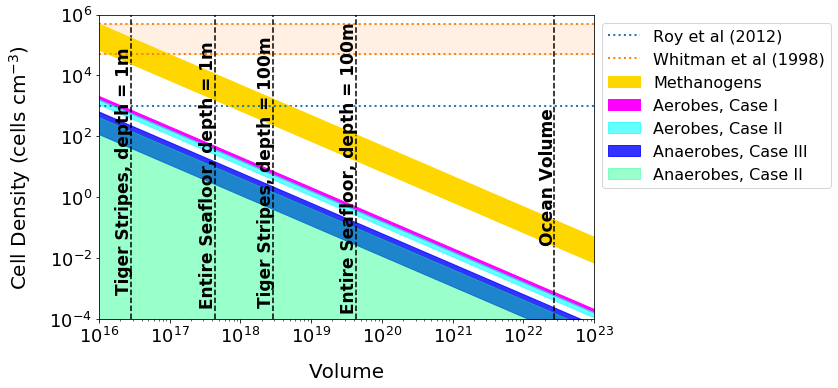

In [49]:
# y_low1 = np.zeros(1229 - 230)
# y_high1 = np.zeros(1229 - 230)
# y_low1[:] = 1e-10
# y_high1[:] = 1e11
# y_low2 = np.zeros(1817 - 818)
# y_high2 = np.zeros(1817 - 818)
# y_low2[:] = 1e-10
# y_high2[:] = 1e11
# y_low3 = np.zeros(1229 - 818)
# y_high3 = np.zeros(1229 - 818)
# y_low3[:] = 1e-10
# y_high3[:] = 1e11

fig1 = plt.figure(1)
fig1.set_figheight(6.5)
fig1.set_figwidth(11)
plt.clf()
plt.plot([1e16, 1e23], [1e3,1e3], linestyle = ':', linewidth = 2, label = 'Roy et al (2012)')
plt.plot([1e16, 1e23], [5e4,5e4], linestyle = ':', linewidth = 2, color = '#ff7f0e', label = 'Whitman et al (1998)')
plt.plot([1e16, 1e23], [5e5,5e5], linestyle = ':', linewidth = 2, color = '#ff7f0e')
plt.fill_between(V,5e4, 5e5, color = 'peachpuff', alpha = 0.4)
plt.axvline(x = V_TS[0], color = 'k', linestyle = '--') 
plt.text(1.7e16,3e4, 'Tiger Stripes, depth = 1m', fontsize=17, rotation=90, fontweight = 'semibold')
plt.axvline(x = V_TS[2], color = 'k', linestyle = '--') 
plt.text(1.7e18,7e4, 'Tiger Stripes, depth = 100m', fontsize=17, rotation=90, fontweight = 'semibold')
plt.axvline(x = V_floor[0], color = 'k', linestyle = '--') 
plt.text(2.6e17,5e4, 'Entire Seafloor, depth = 1m', fontsize=17, rotation=90, fontweight = 'semibold') 
plt.axvline(x = V_floor[2], color = 'k', linestyle = '--') 
plt.text(2.6e19,2e5, 'Entire Seafloor, depth = 100m', fontsize=17, rotation=90, fontweight = 'semibold') 
plt.axvline(x = V_ocean, color = 'k', linestyle = '--') 
plt.text(1.65e22,3e2, 'Ocean Volume', fontsize=17, rotation=90, fontweight = 'semibold')
plt.loglog(V, max_dense_meth, 'gold', linewidth = 1)
plt.loglog(V, min_dense_meth, 'gold', linewidth = 1)
plt.fill_between(V, min_dense_meth, max_dense_meth, color = 'gold', label = 'Methanogens')
plt.fill_between(V, min_dense_I, max_dense_I, color = 'fuchsia', alpha = 1.0, label = 'Aerobes, Case I')
plt.fill_between(V, min_dense_aeII, max_dense_aeII, color = 'aqua', alpha = 0.6, label = 'Aerobes, Case II')
plt.fill_between(V, min_dense_III, max_dense_III, color = 'blue', alpha = 0.8, label = 'Anaerobes, Case III')
plt.fill_between(V, min_dense_anII, max_dense_anII, color = 'springgreen', alpha = 0.4, label = 'Anaerobes, Case II')

plt.xlabel('Volume')
plt.ylabel('Cell Density (cells cm$^{-3}$)')
#plt.yscale('log')
plt.xlim(1e16,1e23)
plt.ylim(1e-4,1e6)
#plt.title(r"Total O$_{2}$ Concentration in the Ocean")
plt.legend(bbox_to_anchor=(1,1), prop={'size': 16})
#plt.title('Theoretical Cell Densities in the Enceladus seafloor')
plt.subplots_adjust(left=0.125, right=0.75, top=0.8, bottom=0.15)
#plt.grid()
#plt.savefig('./Young Enceladus/CellAbundances_YoungEnceladus.png', bbox_inches = 'tight')
plt.savefig('CellAbundances.png', bbox_inches = 'tight')
plt.show()

In [28]:
V[153:819]

array([  3.43374377e+16,   3.46154223e+16,   3.48956575e+16,
         3.51781614e+16,   3.54629523e+16,   3.57500487e+16,
         3.60394695e+16,   3.63312332e+16,   3.66253591e+16,
         3.69218660e+16,   3.72207734e+16,   3.75221006e+16,
         3.78258673e+16,   3.81320932e+16,   3.84407981e+16,
         3.87520023e+16,   3.90657258e+16,   3.93819892e+16,
         3.97008129e+16,   4.00222178e+16,   4.03462246e+16,
         4.06728544e+16,   4.10021286e+16,   4.13340684e+16,
         4.16686955e+16,   4.20060317e+16,   4.23460988e+16,
         4.26889190e+16,   4.30345146e+16,   4.33829079e+16,
         4.37341218e+16,   4.40881790e+16,   4.44451025e+16,
         4.48049155e+16,   4.51676415e+16,   4.55333040e+16,
         4.59019267e+16,   4.62735337e+16,   4.66481492e+16,
         4.70257974e+16,   4.74065029e+16,   4.77902904e+16,
         4.81771850e+16,   4.85672118e+16,   4.89603961e+16,
         4.93567635e+16,   4.97563397e+16,   5.01591508e+16,
         5.05652229e+16,

In [29]:
V_ocean

2.68132972630073e+22

In [274]:
T_esc = ((1/54)*(6.674e-8)*(0.3*5.974e27)*(2.016/6.022e23))/(1.381e-16 * 0.72*6.378e8)
print(T_esc)

116.92786021968999
